In [1]:
import os
from tqdm.auto import tqdm
%load_ext autoreload
%autoreload 2
from helpers import get_df_from_logdir
import pandas as pd
import plotly.express as px
import numpy as np

pd.set_option('display.max_columns', None)

In [13]:
config_name = 'progressbar_search_stop_after_completes'
path = f"/home/sergei/ray_results/{config_name}/"
trials = os.listdir(path)
trials = [os.path.join(path, trial) for trial in trials]
trials = sorted(filter(os.path.isdir, trials))
print(f"Got {len(trials)} trials")

Got 1487 trials


# Reading trial data

In [14]:
def get_last_epoch(trial):
    """Get last row with epoch data."""
    try:
        df = get_df_from_logdir(trial, do_tqdm=False)
    except FileNotFoundError:
        return None
    if hasattr(df, 'epochs'):
        df = df[df.epochs==max(df.epochs)]
        return df.iloc[0]
    return None

df = [get_last_epoch(trial) for trial in tqdm(trials)]
df = pd.DataFrame([x for x in df if x is not None])
df.to_csv(f'{config_name}.csv', index=False)

In [30]:
df = pd.read_csv(f'{config_name}.csv')
df

,epochs,n_samples,losses/opt1/fit/coeff,losses/opt1/fit/value,losses/opt1/value,metrics/batch_index,metrics/batch_size,images,checkpoint_tune,checkpoint_size,time_this_iter_s,should_checkpoint,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,config/name,config/base_dir,config/db_name,config/sources,config/log_sys_usage,config/_gin__hid__choice,config/_gin__lr__loguniform,config/_gin__pow__uniform,time_since_restore,timesteps_since_restore,iterations_since_restore,perf/cpu_util_percent,perf/ram_util_percent,trial_id,experiment_tag,perf/gpu_util_percent0,perf/vram_util_percent0
0,49900,341,1.0,8.589993e-01,8.589993e-01,0,-1,NaN,NaN,NaN,0.563608,NaN,False,NaN,NaN,500,04e4059dad6847148860e41b9c06db37,2021-01-20_13-18-13,1611148693,399.488683,216566,793d67778520,172.28.0.2,progressbar_search_stop_after_completes,/root/causality-disentanglement-rl/results/pro...,causal_sparse,['/root/causality-disentanglement-rl/sparse_ca...,True,1,0.023587,3.179563,399.488683,0,500,95.5,48.2,0031e_00000,"0__gin__hid__choice=1,_gin__lr__loguniform=0.0...",NaN,NaN
1,49900,341,1.0,9.296187e-01,9.296187e-01,0,-1,NaN,NaN,NaN,0.531397,NaN,False,NaN,NaN,500,7220807ac41b4c538fd54bb841b5960f,2021-01-20_13-18-57,1611148737,442.172324,216563,793d67778520,172.28.0.2,progressbar_search_stop_after_completes,/root/causality-disentanglement-rl/results/pro...,causal_sparse,['/root/causality-disentanglement-rl/sparse_ca...,True,3,0.019437,1.833600,442.172324,0,500,56.8,45.5,0031e_00001,"1__gin__hid__choice=3,_gin__lr__loguniform=0.0...",NaN,NaN
2,49900,341,1.0,5.687579e+00,5.687579e+00,0,-1,NaN,NaN,NaN,0.668694,NaN,False,NaN,NaN,500,7ee6545049794a5895cca5a7b923aafd,2021-01-20_13-18-23,1611148703,409.364840,216564,793d67778520,172.28.0.2,progressbar_search_stop_after_completes,/root/causality-disentanglement-rl/results/pro...,causal_sparse,['/root/causality-disentanglement-rl/sparse_ca...,True,1,0.005510,1.055256,409.364840,0,500,97.3,46.9,0031e_00002,"2__gin__hid__choice=1,_gin__lr__loguniform=0.0...",NaN,NaN
3,49900,341,1.0,3.225811e-02,3.225811e-02,0,-1,NaN,NaN,NaN,0.632819,NaN,False,NaN,NaN,500,1153a8b2d9ff45639d97d128e4d99b13,2021-01-20_13-19-15,1611148755,461.350629,216565,793d67778520,172.28.0.2,progressbar_search_stop_after_completes,/root/causality-disentanglement-rl/results/pro...,causal_sparse,['/root/causality-disentanglement-rl/sparse_ca...,True,2,0.007768,2.477666,461.350629,0,500,47.6,44.2,0031e_00003,"3__gin__hid__choice=2,_gin__lr__loguniform=0.0...",NaN,NaN
4,49900,341,1.0,NaN,NaN,0,-1,NaN,NaN,NaN,0.586356,NaN,False,NaN,NaN,500,a6940b91b9fa4ee597949c60ca679f64,2021-01-20_17-57-03,1611165423,376.936471,306022,793d67778520,172.28.0.2,progressbar_search_stop_after_completes,/root/causality-disentanglement-rl/results/pro...,causal_sparse,['/root/causality-disentanglement-rl/sparse_ca...,True,2,0.000125,0.467442,376.936471,0,500,97.3,66.6,01bd8_00000,"0__gin__hid__choice=2,_gin__lr__loguniform=0.0...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,49900,341,1.0,1.016743e-10,1.016743e-10,0,-1,NaN,NaN,NaN,0.715075,NaN,False,NaN,NaN,500,c273d68eaf894fb28a092ea87f3821ea,2021-01-20_12-14-45,1611141285,724.370306,8859,sergeivolodin,172.28.242.56,progressbar_search_stop_after_completes,/home/sergei/git/science/causality-disentangle...,causal_sparse,['/home/sergei/git/science/causality-disentang...,True,3,0.007759,2.433504,724.370306,0,500,53.9,34.7,fec4b_00005,"5__gin__hid__choice=3,_gin__lr__loguniform=0.0...",0.0,0.093994
1482,49900,341,1.0,9.677564e-02,9.677564e-02,0,-1,NaN,NaN,NaN,0.751203,NaN,False,NaN,NaN,500,6db26b18aafb48dd845b4af8655f928f,2021-01-20_12-14-27,1611141267,706.535854,8864,sergeivolodin,172.28.242.56,progressbar_search_stop_after_completes,/home/sergei/git/science/causality-disentangle...,causal_sparse,['/home/sergei/git/science/causality-disent

In [31]:
del df['losses/opt1/value']

In [32]:
all_fields = [c for c in df.columns if any([c.startswith(t) for t in ['losses', 'metrics', 'config']])]
all_fields = [f for f in all_fields if len(set(df[f])) > 1]
all_fields.remove('config/base_dir')
all_fields

['losses/opt1/fit/value',
 'config/sources',
 'config/_gin__hid__choice',
 'config/_gin__lr__loguniform',
 'config/_gin__pow__uniform']

In [33]:
def removeprefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  # or whatever


def shorten(x):
    x = removeprefix(x, 'losses/opt1/')
    x = removeprefix(x, 'config/_gin__')
    x = removeprefix(x, 'metrics/')
    return x
labels = {x: shorten(x) for x in all_fields}

In [34]:
for c in df.columns:
    if c.endswith('loguniform'):
        df[c] = np.log10(df[c])

In [35]:
df['losses/opt1/fit/value'] = np.log10(df['losses/opt1/fit/value'])

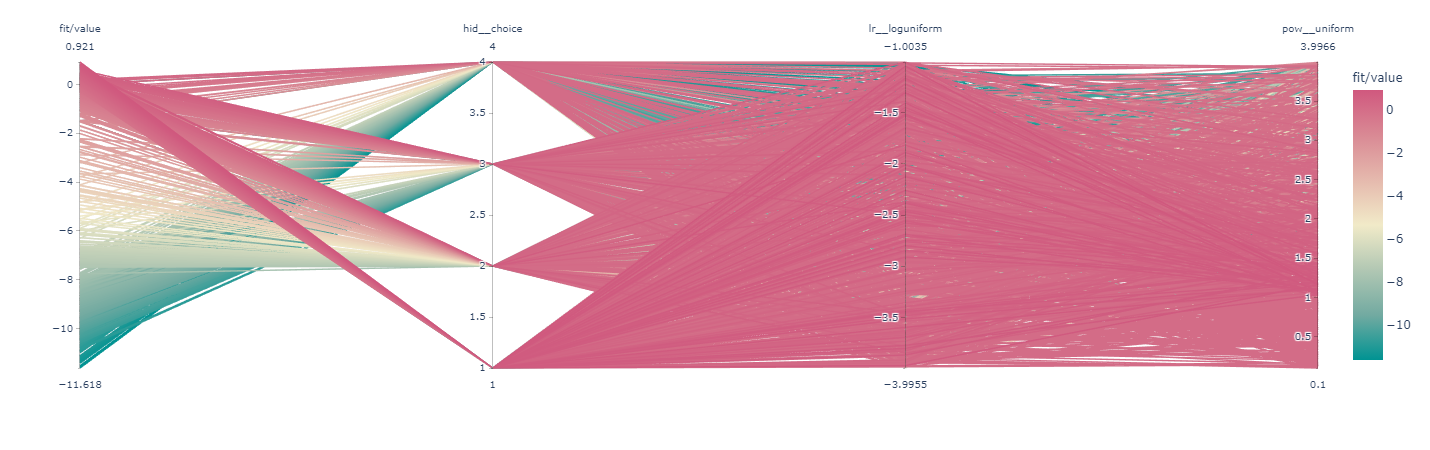

In [37]:
fig = px.parallel_coordinates(df[all_fields], color="losses/opt1/fit/value",
                              labels=labels,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()